In [190]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use("v_paper")
import deepdish as dd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib as mpl
## CLASSIFIER - Evaluation of the techniques via confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import random
from sklearn.utils import shuffle

In [191]:
import seaborn as sns

In [192]:
esum = dd.io.load("experiments_summary.h5")
lobe_data= pd.DataFrame(esum["lobe_summary"])
lobe_activities = np.row_stack(esum["df_fs"])

In [193]:
 plt.rcParams["font.family"] = "Arial"

In [194]:
lobe_data["df_f"] = np.mean(lobe_activities[:, 31:35], 1)

In [195]:
Lobes=lobe_data.lobe.unique()
LobesGreek=['α1', 'α2', 'α3', "α'1", "α'2", "α'3", 'β1', 'β2', "β'1", "β'2",
       'γ1', 'γ2', 'γ3', 'γ4', 'γ5']

dictionaryGreek = dict(zip(Lobes, LobesGreek))

lobe_data["greek_lobe"] = [dictionaryGreek[l] for l in lobe_data.lobe]

In [196]:
lobe_data=lobe_data.replace("1-Heptanone",'2-Heptanone')

In [197]:
Odor_type_map = {
"high_Vinegar": 1,
"Vinegar": 1,
"Yeast": 1,
"Isoamylacetate": 1,
"2-Heptanone": 2,
"cVA": 1,
        "3Octanol":3,
        "Ethanol": 3,

"1-Hexanol":3,
"Peppermint":4,
"4MCH":3,
"Citronella":4,
"Geosmin":3,
}
#ester:1, ketone:2, alcohol:3, terpene:4

lobe_data["odor_type"] = [Odor_type_map[s] for s in lobe_data.stimulus]

In [198]:
valence_map = {
"high_Vinegar": np.nan,
"Vinegar": 1,
"Yeast": 1,
"Isoamylacetate": np.nan,
"2-Heptanone": np.nan, 
"cVA": np.nan,
        "3Octanol": -1,
        "Ethanol": np.nan,

"1-Hexanol": np.nan,
"Peppermint": -1,
"4MCH": -1,
"Citronella": -1,
"Geosmin": -1,
}

lobe_data["valence"] = [valence_map[s] for s in lobe_data.stimulus]

In [199]:
lobes = lobe_data.lobe.unique()
n_lobes = len(lobes)
n_time = lobe_activities.shape[1]

In [200]:
N=10000

In [201]:
Flies=lobe_data.fly_id.unique()
len(Flies)

201

In [202]:
lobe_data=lobe_data[lobe_data["stimulus"]!="high_Vinegar"]


In [203]:
Flies=lobe_data.fly_id.unique()
len(Flies)

185

# LDA starvation

In [15]:
lobe_data_st=lobe_data[lobe_data.hours_starved.isin({0,48})]

lobe_data_st=lobe_data_st.set_index(np.array(range(len(lobe_data_st))))

In [16]:
Samples_st=np.int(len(lobe_data_st)/15)

In [17]:
Hours_starved=np.zeros((Samples_st,1))
for i in range(Samples_st):
    Hours_starved[i]=lobe_data_st["hours_starved"][i*15]    

In [18]:
Lobe_mean_activity_matrix_st=np.zeros((Samples_st,15))
#Lobe_odor_tensor=np.zeros((107,15,80))
for i in range(int(len(lobe_data_st)/15)):
    for j in range(15):
        Lobe_mean_activity_matrix_st[i,j]=lobe_data_st["df_f"][i*15+j]        
        #Lobe_odor_tensor[i,j,:]=lobe_activities[i*15+j,:] 
        #print(lobe_data["lobe"][i*15+j])

In [19]:
Xst = Lobe_mean_activity_matrix_st
yst = Hours_starved

In [20]:
clf_st = LinearDiscriminantAnalysis()
X_lda_st = clf_st.fit(Xst,yst.reshape((Samples_st,))).transform(Xst)

In [21]:
yst_chance_a=yst.reshape((Samples_st,))

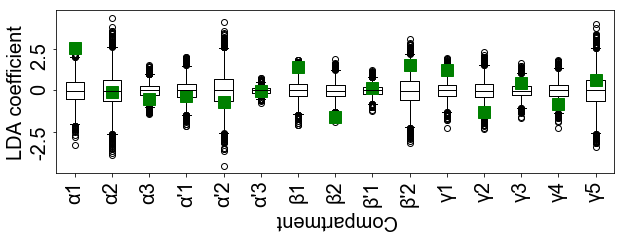

In [22]:
clf_st_chance = LinearDiscriminantAnalysis()
LDA1coeff_chance=np.zeros((15,N))  
for i in range(N):
    yst_chance=shuffle(yst_chance_a)
    X_lda_st_chance = clf_st_chance.fit(Xst,yst_chance).transform(Xst)
    LDA1coeff_chance[:,i]=clf_st_chance.coef_
    #plt.plot(clf_st_chance.coef_.T[::-1],range(15),'s',markersize=6,color='blue')

medianprops = dict(color='black')
fig = plt.figure(figsize=(10, 3))
mpl.rcParams.update({'font.size': 20})    
plt.boxplot(LDA1coeff_chance.T,medianprops=medianprops) 
plt.plot(range(1,16),clf_st.coef_.reshape((15)),'s',markersize=12,color='green')

plt.xlabel('Compartment',rotation=180)
plt.ylabel('LDA coefficient')
plt.xticks(range(1,16),
           LobesGreek,rotation=90)
plt.yticks([-2.5,0,2.5],
           [-2.5,0,2.5],rotation=90)
# draw vertical line from (70,100) to (70, 250)
#plt.plot([0, 0], [-1, 16], linestyle='--',color='black')

#plt.ylim([-1,15])
plt.savefig('CoeffLDAHunger.svg')
plt.savefig('CoeffLDAHunger.png')
plt.show()

# Classification starvation

In [23]:
clf_st = LinearDiscriminantAnalysis()
X_lda_st = clf_st.fit(Xst,yst.reshape((Samples_st,))).transform(Xst)

In [24]:
classifier = LogisticRegression(solver='lbfgs')

def perform_evaluation(feature_set,target_set):
    def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj]
    #print("Evaluation for:",namestr(feature_set,globals())[0])
    feat_train, feat_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.3)

    classifier.fit(feat_train, target_train)
    predicted = classifier.predict(feat_test)

    return accuracy_score(target_test, predicted)

Ac_st=np.zeros((N))
Ac_st_chance=np.zeros((N))

for i in range(N):
    Ac_st[i]=perform_evaluation(Xst, yst.reshape((Samples_st,)))

for i in range(N):
    yst_chance=shuffle(yst_chance_a)
    clf_st = LinearDiscriminantAnalysis()
   # X_lda_st_chance = clf_st.fit(Xst,yst.reshape((Samples_st,))).transform(Xst)
    Ac_st_chance[i]=perform_evaluation(Xst, yst_chance)
    

# Need to average accuracy over many trials

In [25]:
print("Accuracy",np.mean(Ac_st),"versus chance:",np.mean(Ac_st_chance))

Accuracy 0.6461611111111111 versus chance: 0.5720222222222221


In [26]:
len(Ac_st_chance[Ac_st_chance>=np.mean(Ac_st)])/len(Ac_st_chance)

0.0369

(array([2.000e+00, 2.700e+01, 1.810e+02, 1.358e+03, 2.467e+03, 2.886e+03,
        2.460e+03, 4.900e+02, 1.180e+02, 1.100e+01]),
 array([0.37777778, 0.41444444, 0.45111111, 0.48777778, 0.52444444,
        0.56111111, 0.59777778, 0.63444444, 0.67111111, 0.70777778,
        0.74444444]),
 <a list of 10 Patch objects>)

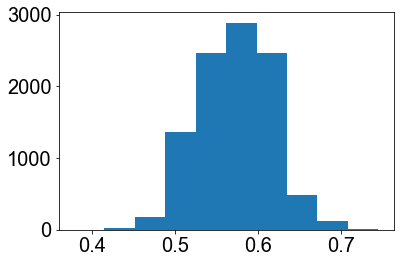

In [27]:
plt.hist(Ac_st_chance)

In [28]:
Xst.shape

(297, 15)

In [29]:
Ac_st=np.zeros((N,15))

for j in range(15):    
    for i in range(N):
        Ac_st[i,j]=perform_evaluation(Xst[:,j].reshape((Samples_st,1)), yst.reshape((Samples_st,)))


In [30]:
for i in range(15):
    print(LobesGreek[i],np.mean(Ac_st,0)[i])

α1 0.6445922222222127
α2 0.6058288888888862
α3 0.6061222222222139
α'1 0.6059511111111066
α'2 0.6050033333333248
α'3 0.6055788888888846
β1 0.6415911111111008
β2 0.6134533333333274
β'1 0.5871711111111063
β'2 0.6297655555555497
γ1 0.6037533333333263
γ2 0.6061977777777714
γ3 0.6027588888888831
γ4 0.6118533333333273
γ5 0.6025733333333281


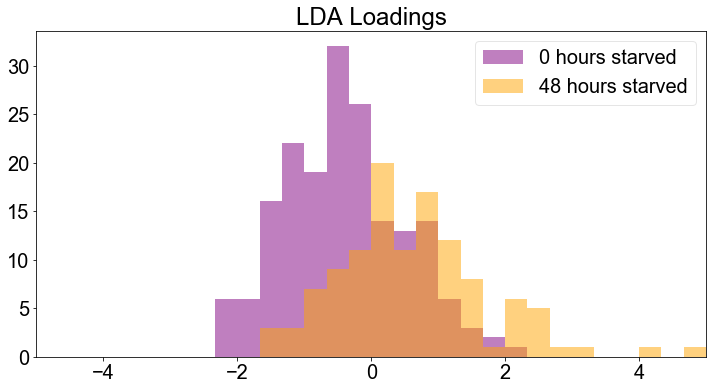

In [31]:
import math
mpl.rcParams.update({'font.size': 20})
min_b = math.floor(np.min(X_lda_st))
max_b = math.ceil(np.max(X_lda_st))
bins = np.linspace(min_b, max_b, 25)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
# plottling the histograms
for h,col in zip((0,48), ((1.0, 1.0,0), (1.0, 0.9977854671280277, 0.7945866974240677))):
    if h==0:
        cmap="Purple"
    if h==48:
        cmap="orange"
    ax.hist(X_lda_st[yst==h],
                   color=cmap,
                   label=str(h)+" hours starved",
                   bins=bins,
                   alpha=0.5)

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=20)
    leg.get_frame().set_alpha(0.5)
    ax.set_title('LDA Loadings')

xst = X_lda_st[yst==0]
x2st = X_lda_st[yst==48]
nx = len(xst)
ny = len(x2st)
dof = nx + ny - 2

dp_st=(np.mean(xst) - np.mean(x2st)) / np.sqrt(((nx-1)*np.std(xst, ddof=1) ** 2 + (ny-1)*np.std(x2st, ddof=1) ** 2) / dof)

plt.xlim([-5,5])
plt.show()
fig.savefig('HistClassificationHunger_nohighVinegar.svg')

In [32]:
dp_st

-1.0114752400352478

0.004720053550305324


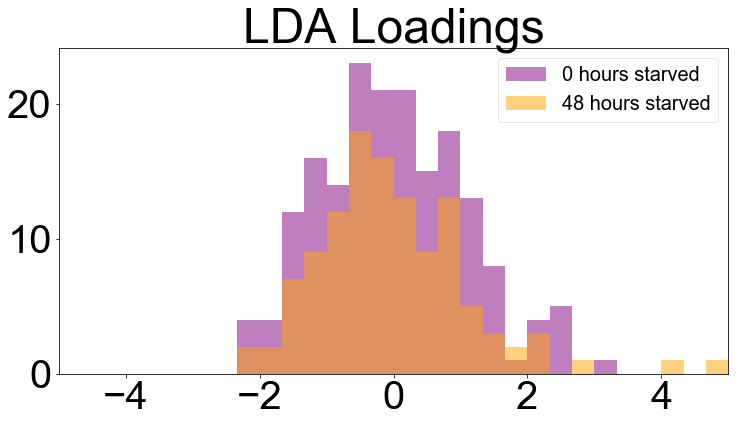

In [33]:
import math
yst_chance=shuffle(yst_chance_a)
clf_st = LinearDiscriminantAnalysis()
X_lda_st_chance = clf_st.fit(Xst,yst.reshape((Samples_st,))).transform(Xst)

Ac_st_chance[i]=perform_evaluation(Xst, yst_chance)
mpl.rcParams.update({'font.size': 40})
min_b = math.floor(np.min(X_lda_st))
max_b = math.ceil(np.max(X_lda_st))
bins = np.linspace(min_b, max_b, 25)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
# plottling the histograms
for h,col in zip((0,48), ((1.0, 1.0,0), (1.0, 0.9977854671280277, 0.7945866974240677))):
    if h==0:
        cmap="Purple"
    if h==48:
        cmap="orange"
    ax.hist(X_lda_st_chance[yst_chance==h],
                   color=cmap,
                   label=str(h)+" hours starved",
                   bins=bins,
                   alpha=0.5)

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=20)
    leg.get_frame().set_alpha(0.5)
    
    ax.set_title('LDA Loadings')

xst = X_lda_st_chance[yst_chance==0]
x2st = X_lda_st_chance[yst_chance==48]
nx = len(xst)
ny = len(x2st)
dof = nx + ny - 2

dp_st_chance=(np.mean(xst) - np.mean(x2st)) / np.sqrt(((nx-1)*np.std(xst, ddof=1) ** 2 + (ny-1)*np.std(x2st, ddof=1) ** 2) / dof)

print(dp_st_chance)
plt.xlim([-5,5])
plt.show()
fig.savefig('HistClassificationHunger_chance_no_Highvinegar.svg')

In [34]:
dp_st_chance=np.zeros((N))  

for i in range(N):
    yst_chance=shuffle(yst_chance_a)
    clf_st = LinearDiscriminantAnalysis()
    X_lda_st_chance = clf_st.fit(Xst,yst_chance).transform(Xst)
    xst = X_lda_st_chance[yst_chance==0]
    x2st = X_lda_st_chance[yst_chance==48]
    nx = len(xst)
    ny = len(x2st)
    dof = nx + ny - 2

    dp_st_chance[i]=(np.mean(xst) - np.mean(x2st)) / np.sqrt(((nx-1)*np.std(xst, ddof=1) ** 2 + (ny-1)*np.std(x2st, ddof=1) ** 2) / dof)


In [35]:
np.mean(dp_st_chance)

-0.4648710415835966

In [36]:
np.std(dp_st_chance)

0.0872315927850886

In [37]:
np.sum(dp_st_chance)

-4648.710415835966

(array([   7.,   37.,  231.,  809., 1860., 2801., 2489., 1369.,  374.,
          23.]),
 array([-0.83401709, -0.76936252, -0.70470794, -0.64005336, -0.57539879,
        -0.51074421, -0.44608963, -0.38143506, -0.31678048, -0.25212591,
        -0.18747133]),
 <a list of 10 Patch objects>)

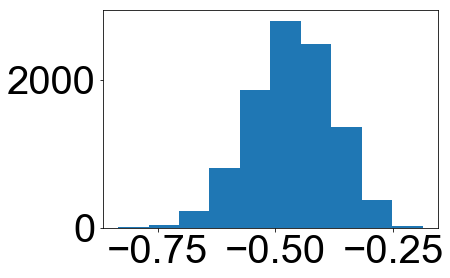

In [38]:
plt.hist(dp_st_chance)

In [39]:
len(dp_st_chance[dp_st_chance<=dp_st])/len(dp_st_chance)

0.0

In [40]:
# Upper bound
np.min(dp_st_chance)/np.sum(dp_st_chance)

0.00017940826997151895

# LDA valence

In [41]:
lobe_data_val=lobe_data[lobe_data.valence.isin({1,-1})]

lobe_data_val=lobe_data_val.set_index(np.array(range(len(lobe_data_val))))

Samples_val=np.int(len(lobe_data_val)/15)

In [42]:
Lobe_mean_activity_matrix_val=np.zeros((Samples_val,15))
#Lobe_odor_tensor=np.zeros((107,15,80))
for i in range(Samples_val):
    for j in range(15):
        Lobe_mean_activity_matrix_val[i,j]=lobe_data_val["df_f"][i*15+j]        
        #Lobe_odor_tensor[i,j,:]=lobe_activities[i*15+j,:] 
        #print(lobe_data["lobe"][i*15+j])

In [43]:
Valence=np.zeros((Samples_val,1))
for i in range(Samples_val):
    Valence[i]=lobe_data_val["valence"][i*15]

In [44]:
Xval = Lobe_mean_activity_matrix_val
yval = Valence

clf_val = LinearDiscriminantAnalysis()
X_lda_val = clf_val.fit(Xval,yval.reshape((Samples_val,))).transform(Xval)

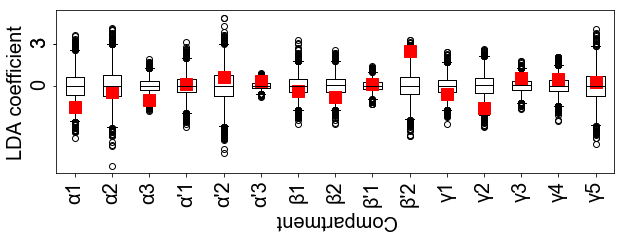

In [45]:
yval_chancea=yval.reshape((Samples_val,))

clf_val_chance = LinearDiscriminantAnalysis()

LDA1coeff_chance_val=np.zeros((15,N))  

for i in range(N):
    yval_chance=shuffle(yval_chancea)
    Xval_lda_chance = clf_val_chance.fit(Xval,yval_chance).transform(Xval)
    LDA1coeff_chance_val[:,i]=clf_val_chance.coef_
    #plt.plot(clf_st_chance.coef_.T[::-1],range(15),'s',markersize=6,color='blue')
 

medianprops = dict(color='black')
fig = plt.figure(figsize=(10, 3))
mpl.rcParams.update({'font.size': 20})    
plt.boxplot(LDA1coeff_chance_val.T,medianprops=medianprops) 

plt.xlabel('Compartment')
plt.ylabel('LDA coefficient')
plt.xticks(range(1,16),
           LobesGreek,rotation=90)
plt.yticks([3,0,3],
           [3,0,3],rotation=90)  

plt.plot(range(1,16),clf_val.coef_.T,'s',markersize=12,color='red')
plt.xlabel('Compartment',rotation=180)
plt.xticks(range(1,16),
           LobesGreek)
plt.savefig('CoeffLDAValence.svg')
plt.savefig('CoeffLDAValence.png')
plt.show()


# Classification valence

In [46]:
## CLASSIFIER - Evaluation of the techniques via confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
 
classifier = LogisticRegression(solver='lbfgs')


def perform_evaluation(feature_set,target_set):
    def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj]
    #print("Evaluation for:",namestr(feature_set,globals())[0])
    feat_train, feat_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.3)
# pass initial state to generate same indexes
 
    classifier.fit(feat_train, target_train)
    predicted = classifier.predict(feat_test)
    #In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
    return accuracy_score(target_test, predicted)

Ac_val=np.zeros((N))
for i in range(N):
    Ac_val[i]=perform_evaluation(Xval, yval.reshape((Samples_val,)))
    
Ac_val_chance=np.zeros((N))

for i in range(N):
    yval_chance=shuffle(yval_chancea)
    #clf_val_chance = LinearDiscriminantAnalysis()
    #clf_val_chance.fit(Xval, yval_chance)
    #X_lda_val_chance = clf_val_chance.fit(Xval,yval_chance.reshape((Samples_val,))).transform(Xval)
    Ac_val_chance[i]=perform_evaluation(Xval, yval_chance)


(array([  75.,  243.,  669., 1472., 2211., 3412., 1269.,  503.,  123.,
          23.]),
 array([0.52307692, 0.55692308, 0.59076923, 0.62461538, 0.65846154,
        0.69230769, 0.72615385, 0.76      , 0.79384615, 0.82769231,
        0.86153846]),
 <a list of 10 Patch objects>)

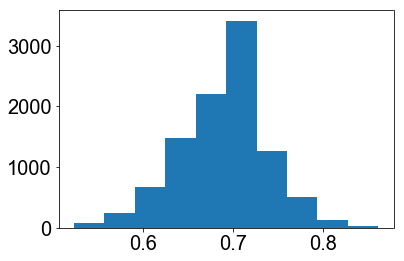

In [47]:
plt.hist(Ac_val)

(array([2.000e+00, 2.600e+01, 2.660e+02, 1.299e+03, 1.766e+03, 3.244e+03,
        2.380e+03, 8.500e+02, 1.570e+02, 1.000e+01]),
 array([0.32307692, 0.36615385, 0.40923077, 0.45230769, 0.49538462,
        0.53846154, 0.58153846, 0.62461538, 0.66769231, 0.71076923,
        0.75384615]),
 <a list of 10 Patch objects>)

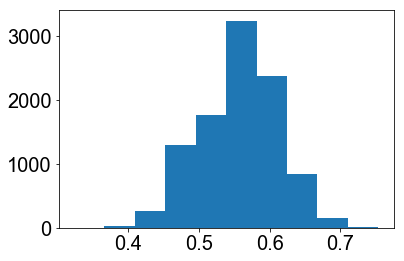

In [48]:
plt.hist(Ac_val_chance)

In [49]:
print("Accuracy: ",np.mean(Ac_val),"versus chance:",np.mean(Ac_val_chance))
#print(confusion_matrix(target_test, predicted))

Accuracy:  0.6875215384615384 versus chance: 0.5542338461538461


In [50]:
len(Ac_val_chance[Ac_val_chance>=np.mean(Ac_val)])/len(Ac_val_chance)

0.0077

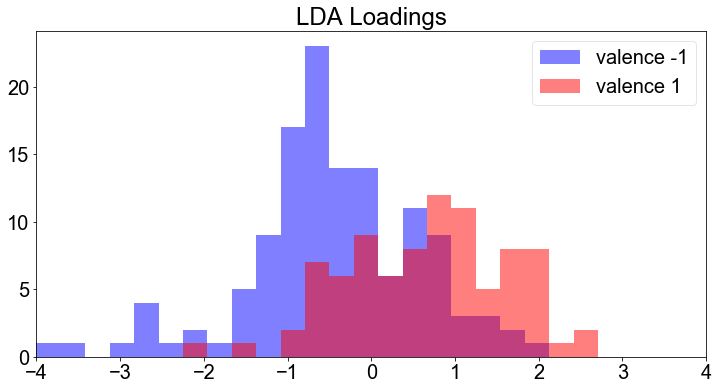

In [51]:
import math
mpl.rcParams.update({'font.size': 20})
min_b = math.floor(np.min(X_lda_val))
max_b = math.ceil(np.max(X_lda_val))
bins = np.linspace(min_b, max_b, 25)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
# plottling the histograms
for h,col in zip((-1,1), ('blue', 'red')):
    ax.hist(X_lda_val[yval==h],
                   color=col,
                   label="valence "+str(h),
                   bins=bins,
                   alpha=0.5)

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=20)
    leg.get_frame().set_alpha(0.5)
    ax.set_title('LDA Loadings')


    # remove axis spines
    #ax.spines["top"].set_visible(False)  
    #ax.spines["right"].set_visible(False)
    #ax.spines["bottom"].set_visible(False)
    #ax.spines["left"].set_visible(False)    
# test conditions
x = X_lda_val[yval==-1]
x2 = X_lda_val[yval==1]
nx = len(x)
ny = len(x2)
dof = nx + ny - 2

dp_val=(np.mean(x) - np.mean(x2)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(x2, ddof=1) ** 2) / dof)
plt.xlim([-4,4])
plt.show()
fig.savefig('HistClassificationValenceVrevWoctMCH.svg')

In [52]:
dp_val

-1.1170038140517515

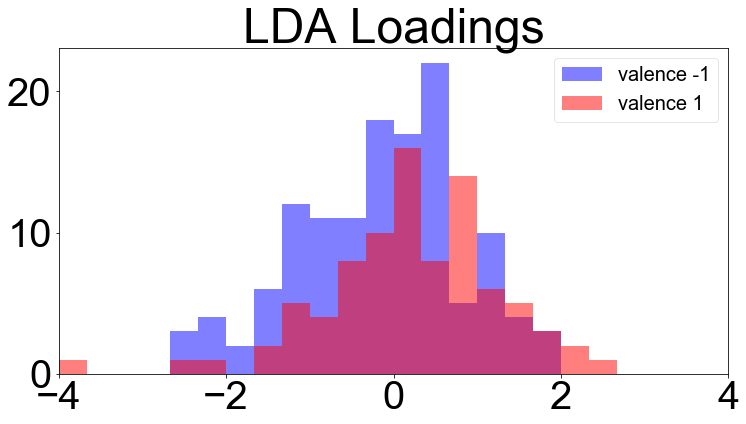

In [53]:
yval_chance=shuffle(yval_chancea)
    #clf_val_chance = LinearDiscriminantAnalysis()
    #clf_val_chance.fit(Xval, yval_chance)
X_lda_val_chance = clf_val_chance.fit(Xval,yval_chance.reshape((Samples_val,))).transform(Xval)

mpl.rcParams.update({'font.size': 40})
min_b = math.floor(np.min(Xval_lda_chance))
max_b = math.ceil(np.max(Xval_lda_chance))
bins = np.linspace(min_b, max_b, 25)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
# plottling the histograms
for h,col in zip((-1,1), ('blue', 'red')):
    ax.hist(X_lda_val_chance[yval_chance==h],
                   color=col,
                   label="valence "+str(h),
                   bins=bins,
                   alpha=0.5)

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=20)
    leg.get_frame().set_alpha(0.5)
    ax.set_title('LDA Loadings')


    # remove axis spines
    #ax.spines["top"].set_visible(False)  
    #ax.spines["right"].set_visible(False)
    #ax.spines["bottom"].set_visible(False)
    #ax.spines["left"].set_visible(False)    
# test conditions
x = Xval_lda_chance[yval_chance==-1]
x2 = Xval_lda_chance[yval_chance==1]
nx = len(x)
ny = len(x2)
dof = nx + ny - 2

dp_val_chance=(np.mean(x) - np.mean(x2)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(x2, ddof=1) ** 2) / dof)
plt.xlim([-4,4])
plt.show()
fig.savefig('HistClassificationValenceChancevRevvOctMCH.svg')

In [54]:
dp_val_chance=np.zeros((N))  

for i in range(N):
    yval_chance=shuffle(yval_chancea)
    Xval_lda_chance = clf_val_chance.fit(Xval,yval_chance).transform(Xval)
    x = Xval_lda_chance[yval_chance==-1]
    x2 = Xval_lda_chance[yval_chance==1]
    nx = len(x)
    ny = len(x2)
    dof = nx + ny - 2

    dp_val_chance[i]=(np.mean(x) - np.mean(x2)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(x2, ddof=1) ** 2) / dof)

(array([1.600e+01, 1.000e+02, 4.280e+02, 1.287e+03, 2.480e+03, 3.038e+03,
        1.935e+03, 6.330e+02, 8.000e+01, 3.000e+00]),
 array([-0.97004746, -0.88858768, -0.8071279 , -0.72566812, -0.64420833,
        -0.56274855, -0.48128877, -0.39982899, -0.31836921, -0.23690943,
        -0.15544965]),
 <a list of 10 Patch objects>)

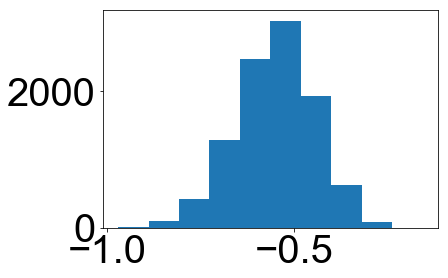

In [55]:
plt.hist(dp_val_chance)

In [56]:
np.mean(dp_val_chance)

-0.5492373070416672

In [57]:
np.std(dp_val_chance)

0.10542038609156838

In [58]:
len(dp_val_chance[dp_val_chance<=dp_val])/len(dp_val_chance)

0.0

In [59]:
1/len(dp_val_chance)

0.0001

In [60]:
np.sum(dp_val_chance[dp_val_chance<dp_val])/np.sum(dp_val_chance)

-0.0

In [61]:
Xval.shape

(215, 15)

In [62]:
## CLASSIFIER - Evaluation of the techniques via confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
 
classifier = LogisticRegression(solver='lbfgs')


Ac_val=np.zeros((N,15))

for j in range(15):
    def perform_evaluation(feature_set,target_set):
        def namestr(obj, namespace):
            return [name for name in namespace if namespace[name] is obj]
        #print("Evaluation for:",namestr(feature_set,globals())[0])
        feat_train, feat_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.3)
    # pass initial state to generate same indexes

        classifier.fit(feat_train, target_train)
        predicted = classifier.predict(feat_test)
        #In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
        return accuracy_score(target_test, predicted)

    for i in range(N):
        Ac_val[i,j]=perform_evaluation(Xval[:,j].reshape((Samples_val,1)), yval.reshape((Samples_val,)))
    


In [63]:
LobesGreek

['α1',
 'α2',
 'α3',
 "α'1",
 "α'2",
 "α'3",
 'β1',
 'β2',
 "β'1",
 "β'2",
 'γ1',
 'γ2',
 'γ3',
 'γ4',
 'γ5']

In [64]:
for i in range(15):
    print(LobesGreek[i],np.mean(Ac_val,0)[i])


α1 0.594676923076923
α2 0.5877261538461522
α3 0.6531692307692456
α'1 0.6250076923077
α'2 0.5925369230769242
α'3 0.5879892307692322
β1 0.5913261538461562
β2 0.5650953846153792
β'1 0.5792184615384607
β'2 0.5743030769230743
γ1 0.5917107692307758
γ2 0.6297938461538531
γ3 0.5925830769230742
γ4 0.6371338461538573
γ5 0.5873492307692323


# LDA Stimulus

In [204]:
OdorID_map = {
"Vinegar": 0,
"Yeast": 1,
"Isoamylacetate": 2,
"2-Heptanone": 3,
    
"cVA": 4,
        "3Octanol": 5,
        "Ethanol": 6,

"1-Hexanol": 7,
"Peppermint": 8,
"4MCH": 9,
"Citronella": 10,
"Geosmin": 11,
}


In [205]:
Samples=np.int(len(lobe_data)/15)

lobe_data=lobe_data.reset_index()

Lobe_mean_activity_matrix=np.zeros((Samples,15))
#Lobe_odor_tensor=np.zeros((107,15,80))
for i in range(Samples):
    for j in range(15):
        Lobe_mean_activity_matrix[i,j]=lobe_data["df_f"][i*15+j]        
        #Lobe_odor_tensor[i,j,:]=lobe_activities[i*15+j,:] 
        #print(lobe_data["lobe"][i*15+j])

Correlation matrix

In [206]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [207]:
Lobe_mean_activity_matrix.shape

(332, 15)

([<matplotlib.axis.YTick at 0x16f24bce828>,
 <a list of 15 Text yticklabel objects>)

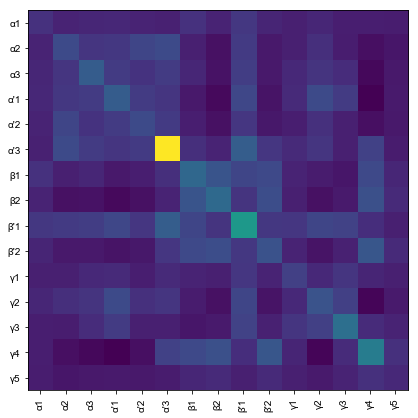

In [208]:
CorrMat=np.cov(Lobe_mean_activity_matrix.T)
plt.figure(figsize=(7, 7))
plt.imshow(CorrMat)
plt.xticks(range(15),LobesGreek,rotation='vertical')
plt.yticks(range(15),LobesGreek)

In [209]:
# generate the linkage matrix
Z = linkage(CorrMat, 'ward')

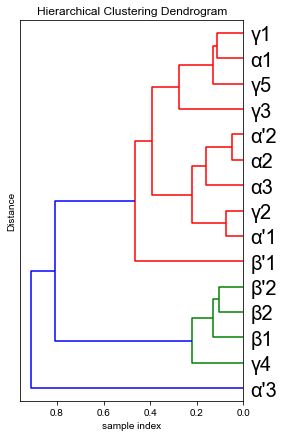

In [210]:
# calculate full dendrogram
plt.figure(figsize=(4, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(
    Z,
    orientation="left", 
    labels=LobesGreek,
    leaf_font_size=20
)

plt.savefig('CorrelationDendogram.svg')

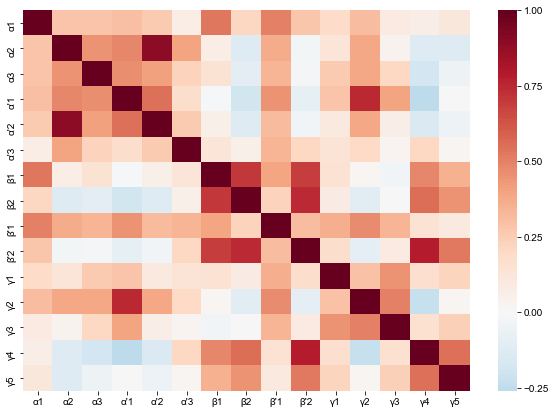

In [211]:
plt.figure(figsize=(10, 7))

Lobe_Odor=pd.DataFrame(data=Lobe_mean_activity_matrix)
# calculate the correlation matrix
corr = Lobe_Odor.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=LobesGreek,
        yticklabels=LobesGreek,center=0, cmap='RdBu_r')

plt.savefig('CorrelationMatrixV2.svg')

In [212]:
Lobes

array(['a1', 'a2', 'a3', 'ap1', 'ap2', 'ap3', 'b1', 'b2', 'bp1', 'bp2',
       'g1', 'g2', 'g3', 'g4', 'g5'], dtype=object)

In [213]:
ExpId=lobe_data.experiment_id.unique()

In [214]:
Odors=lobe_data.stimulus.unique()

In [215]:
Odors

array(['Citronella', 'Vinegar', 'Yeast', 'Peppermint', '2-Heptanone',
       '1-Hexanol', 'cVA', 'Geosmin', '4MCH', 'Isoamylacetate',
       '3Octanol', 'Ethanol'], dtype=object)

In [216]:
Lobe_mean_matrix=np.zeros((12,15))
k=0
for Lobe in Lobes:
    Lobe_data=lobe_data[lobe_data.lobe==Lobe]
    Lobe_odors=np.zeros((12,10))
    Lobe_mean=np.zeros((12,1)) 
    i=0
    j=0
    for odor in Odors:
        for eid in ExpId:
            Lobe_data_eid=Lobe_data[Lobe_data["experiment_id"]==eid]
            Lobe_specific_odor_help=np.array(Lobe_data_eid[Lobe_data_eid["stimulus"]==odor]["df_f"])
            if Lobe_specific_odor_help != []:        
                Lobe_specific_odor=Lobe_specific_odor_help[0]
                del Lobe_specific_odor_help
                Lobe_odors[j,i]=Lobe_specific_odor
                i=i+1
            Lobe_mean[j]=np.mean(Lobe_odors[j,range(i-1)])
            Lobe_mean_matrix[j,k]=Lobe_mean[j]
        j=j+1
        i=0
    k=k+1
           

    del Lobe_mean

C:\Users\aimon\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  del sys.path[0]
C:\Users\aimon\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\aimon\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\aimon\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  del sys.path[0]


KeyboardInterrupt: 

In [ ]:
CorrMatSim=np.cov(Lobe_mean_matrix.T)
plt.figure(figsize=(7, 7))
plt.imshow(Lobe_mean_matrix)
plt.xticks(range(15),LobesGreek,rotation='vertical')
plt.yticks(range(15),LobesGreek)

In [ ]:
Lobe_mean_matrix.shape

In [217]:
import seaborn as sns
Lobe_Odor=pd.DataFrame(data=Lobe_mean_matrix)
# calculate the correlation matrix
corr = Lobe_Odor.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=LobesGreek,
        yticklabels=LobesGreek,center=0)

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
Lobe_mean_matrix[:,Dend_Lobes["leaves"]]

In [ ]:
Z = linkage(CorrMatSim, 'ward')
plt.figure(figsize=(6, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(
    Z,
    orientation="left", 
    labels=LobesGreek,
    leaf_font_size=20
)
plt.show()

In [ ]:
Lobe_Odor=pd.DataFrame(data=Lobe_mean_matrix)
# calculate the correlation matrix
corr = Lobe_Odor.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=Lobes,
        yticklabels=Lobes,center=0)

# Classification

In [251]:
lobe_data=lobe_data[lobe_data["virgin"]==False]

Samples=np.int(len(lobe_data)/15)

lobe_data=lobe_data.reset_index()

Lobe_mean_activity_matrix=np.zeros((Samples,15))
#Lobe_odor_tensor=np.zeros((107,15,80))
for i in range(Samples):
    for j in range(15):
        Lobe_mean_activity_matrix[i,j]=lobe_data["df_f"][i*15+j]        
        #Lobe_odor_tensor[i,j,:]=lobe_activities[i*15+j,:] 
        #print(lobe_data["lobe"][i*15+j])

In [218]:
Lobe_mean_activity_matrix.shape

(332, 15)

In [219]:
Odor_identity=np.zeros((Samples,1))
for i in range(Samples):
    Odor_identity[i]=OdorID_map[lobe_data["stimulus"][i*15]]

In [220]:
X = Lobe_mean_activity_matrix
y = Odor_identity

clf = LinearDiscriminantAnalysis()
clf.fit(X, y.reshape((Samples,)))
X_lda = clf.fit(X,y.reshape((Samples,))).transform(X)

y_chance=shuffle(y)
clf.fit(X, y_chance.reshape((Samples,)))
X_lda_chance = clf.fit(X,y_chance.reshape((Samples,))).transform(X)

In [221]:
y_chance=shuffle(y.reshape((Samples,)))
clf.fit(X, y_chance)
X_lda_chance = clf.fit(X,y_chance).transform(X)

M=np.zeros((12))
Mchance=np.zeros((12))
Av_vector=np.zeros((12,3))
Av_vector_chance=np.zeros((12,3))

for k in range(12):
    Xsub=np.zeros((sum(map(int,(y==k))),3))
    Xsub_chance=np.zeros((sum(map(int,(y_chance==k))),3))    
    for l in range(3):
        Xhelp=X_lda[:,l].reshape(len(X_lda[:,l]),1)
        Xsub[:,l]=Xhelp[y==k]
        
        Xhelp_chance=X_lda_chance[:,l]
        Xsub_chance[:,l]=Xhelp_chance[y_chance==k]        
    
    
    Mdist=np.zeros((len(Xsub),len(Xsub)))
    Mdist_chance=np.zeros((len(Xsub_chance),len(Xsub_chance)))    
    
    for i in range(len(Xsub)):
        for j in range(len(Xsub)):
            Mdist[i,j]=np.linalg.norm(Xsub[i,:]-Xsub[j,:])
            
    for i in range(len(Xsub_chance)):
        for j in range(len(Xsub_chance)):
            Mdist_chance[i,j]=np.linalg.norm(Xsub_chance[i,:]-Xsub_chance[j,:])   
                                      
    M[k]=np.mean(np.mean(Mdist))
    Mchance[k]=np.mean(np.mean(Mdist_chance))     
    
    Av_vector[k,:]=np.mean(Xsub,0)
    Av_vector_chance[k,:]=np.mean(Xsub_chance,0)
    
    del Xsub
    del Xsub_chance
                                


Mtot=np.zeros((len(X_lda),len(X_lda)))
for i in range(len(X_lda)):
    for j in range(len(X_lda)):
        Mtot[i,j]=np.linalg.norm(X_lda[i,range(3)]-X_lda[j,range(3)])
print(np.mean(np.mean(np.mean(Mtot))))

# Distance between representations
Dist=np.zeros((12,12))
Dist_chance=np.zeros((12,12))
for i in range(12):
    for j in range(12):
        Dist[i,j]=np.linalg.norm(Av_vector[i,:]-Av_vector[j,:])
        Dist_chance[i,j]=np.linalg.norm(Av_vector_chance[i,:]-Av_vector_chance[j,:])
        
print(np.mean(M),"chance:",np.mean(Mchance))                                        
print("Distance between representations:",np.mean(np.mean(Dist))," chance:", np.mean(np.mean(Dist_chance)))

2.676901726340066
2.1198194366762313 chance: 2.130267692415491
Distance between representations: 1.6114785742236282  chance: 0.8209549346325278


In [222]:
Dist_distrib=np.zeros((N))
for k in range (N):
    y_chance=shuffle(y.reshape((Samples,)))
    clf.fit(X, y_chance)
    X_lda_chance = clf.fit(X,y_chance).transform(X)

    Av_vector_chance=np.zeros((12,3))

    for l in range(12):
        Xsub_chance=np.zeros((sum(map(int,(y_chance==l))),3))    
        for m in range(3):
            Xhelp_chance=X_lda_chance[:,m]
            Xsub_chance[:,m]=Xhelp_chance[y_chance==l]        
        Av_vector_chance[l,:]=np.mean(Xsub_chance,0)

    del Xsub_chance
                                

    Dist_chance=np.zeros((12,12))
    for i in range(12):
        for j in range(12):
            Dist_chance[i,j]=np.linalg.norm(Av_vector_chance[i,:]-Av_vector_chance[j,:])
    Dist_distrib[k]=np.mean(np.mean(Dist_chance))

In [223]:
np.std(Dist_distrib)

0.058187567317426706

(array([  32.,  260., 1053., 2502., 2957., 2031.,  865.,  254.,   40.,
           6.]),
 array([0.58296246, 0.62720416, 0.67144585, 0.71568754, 0.75992923,
        0.80417092, 0.84841261, 0.8926543 , 0.93689599, 0.98113768,
        1.02537938]),
 <a list of 10 Patch objects>)

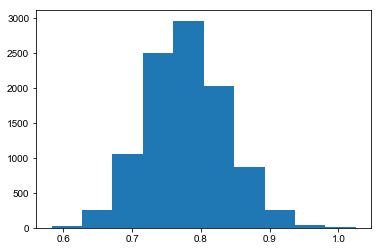

In [224]:
plt.hist(Dist_distrib)

In [225]:
np.mean(Dist_distrib)

0.7785696885282026

In [226]:
print(OdorID_map,M)

{'Vinegar': 0, 'Yeast': 1, 'Isoamylacetate': 2, '2-Heptanone': 3, 'cVA': 4, '3Octanol': 5, 'Ethanol': 6, '1-Hexanol': 7, 'Peppermint': 8, '4MCH': 9, 'Citronella': 10, 'Geosmin': 11} [2.0916517  2.32439399 1.9548315  2.09349029 1.87979749 2.66817187
 1.55191637 2.46739624 2.43239416 2.78734907 1.74414228 1.44229828]


Or to compute the Euclidean distance between the population vectors?  Not sure how we will make sense of those values

# Stimulus classifier

In [227]:
## CLASSIFIER - Evaluation of the techniques via confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
plt.figure(figsize=(10, 10))
#classifier = RandomForestClassifier(max_depth=2, random_state=0,class_weight="balanced")
classifier = LogisticRegression(solver='lbfgs',class_weight="balanced",multi_class="multinomial")
from random import randint

def perform_evaluation(feature_set,target_set):
    def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj]
    #print("Evaluation for:",namestr(feature_set,globals())[0])
    feat_train, feat_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.2, stratify=target_set)
# pass initial state to generate same indexes
 

    classifier.fit(feat_train, target_train)
    predicted = classifier.predict(feat_test)
    #In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
    Ac=accuracy_score(target_test, predicted)
    
    yrand=shuffle(target_test)
        
    Chance=accuracy_score(yrand, predicted)
    ConfMat=confusion_matrix(target_test, predicted)

    return Ac, ConfMat, Chance

Ac=np.zeros((N))
Chance=np.zeros((N))
ConfMat=np.zeros((12,12,N))
for i in range(N):
    [Ac[i], ConfMat[:,:,i], Chance[i]]=perform_evaluation(X_lda, y.reshape((Samples,)))

<Figure size 720x720 with 0 Axes>

Accurancy: 0.3260731343283582
Chance: 0.0888731343283582


Text(0, 0.5, 'actually odor')

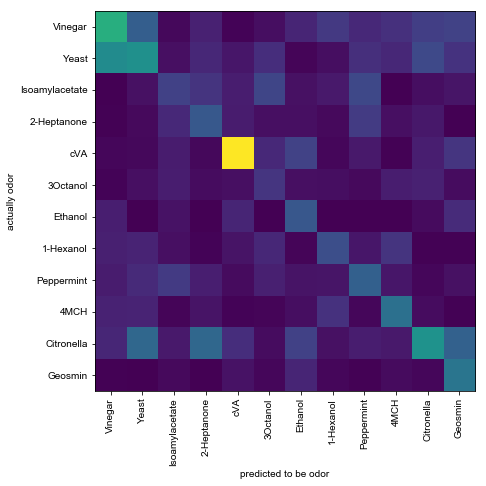

In [228]:
print("Accurancy:", np.mean(Ac))
print("Chance:",np.mean(Chance))
plt.figure(figsize=(7, 7))
plt.imshow(np.mean(ConfMat,2))
plt.xticks(range(12),OdorID_map.keys(),rotation='vertical')
plt.yticks(range(12),OdorID_map.keys())
plt.xlabel("predicted to be odor")
plt.ylabel("actually odor")

In [229]:
## CLASSIFIER - Evaluation of the techniques via confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
plt.figure(figsize=(10, 10))
#classifier = RandomForestClassifier(max_depth=2, random_state=0,class_weight="balanced")
classifier = LogisticRegression(solver='lbfgs',class_weight="balanced",multi_class="multinomial")
from random import randint

def perform_evaluation(feature_set,target_set):
    def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj]
    #print("Evaluation for:",namestr(feature_set,globals())[0])
    feat_train, feat_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.2, stratify=target_set)
# pass initial state to generate same indexes
 

    classifier.fit(feat_train, target_train)
    predicted = classifier.predict(feat_test)
    #In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
    Ac=accuracy_score(target_test, predicted)
    
    yrand=shuffle(target_test)
    Chance=accuracy_score(yrand, predicted)
    ConfMat=confusion_matrix(target_test, predicted)

    return Ac, ConfMat, Chance

Ac=np.zeros((N))
Chance=np.zeros((N))
ConfMat=np.zeros((12,12,N))
for i in range(N):
    [Ac[i], ConfMat[:,:,i], Chance[i]]=perform_evaluation(X, y.reshape((Samples,)))

<Figure size 720x720 with 0 Axes>

Accurancy: 0.29191343283582094
Chance: 0.08550895522388059
fold: 3.413834633712102


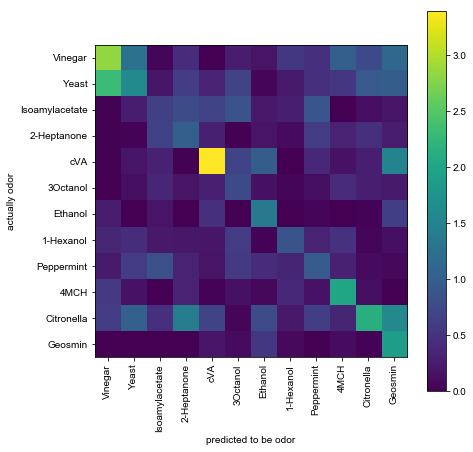

In [230]:
print("Accurancy:", np.mean(Ac))
print("Chance:",np.mean(Chance))
print("fold:",np.mean(Ac)/np.mean(Chance))
plt.figure(figsize=(7, 7))
im=plt.imshow(np.mean(ConfMat,2))
plt.xticks(range(12),OdorID_map.keys(),rotation='vertical')
plt.yticks(range(12),OdorID_map.keys())
plt.xlabel("predicted to be odor")
plt.ylabel("actually odor")
plt.colorbar(im)
plt.savefig('LRclass.svg')
plt.savefig('LRclass.png')

In [256]:
X = Lobe_mean_activity_matrix
y = Odor_identity

clf = LinearDiscriminantAnalysis()
clf.fit(X, y.reshape((Samples,)))
X_lda = clf.fit(X,y.reshape((Samples,))).transform(X)

y_chance=shuffle(y)
clf.fit(X, y_chance.reshape((Samples,)))
X_lda_chance = clf.fit(X,y_chance.reshape((Samples,))).transform(X)

In [258]:
## CLASSIFIER - Evaluation of the techniques via confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn import svm
 
plt.figure(figsize=(7, 7))
classifier = svm.LinearSVC(class_weight="balanced",max_iter=3000)
 
def perform_evaluation(feature_set,target_set):
    def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj]
    feat_train, feat_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.2)
    classifier.fit(feat_train, target_train)
    predicted = classifier.predict(feat_test)
    Ac=accuracy_score(target_test, predicted)    
    yrand=np.zeros((len(target_test)))
    for i in range(len(target_test)):
        yrand[i]=randint(0, 11)        
    Chance=accuracy_score(yrand, predicted)
    ConfMat=confusion_matrix(target_test, predicted)

    return Ac, ConfMat, Chance

Ac=np.zeros((1000))
Chance=np.zeros((1000))
ConfMat=np.zeros((12,12,1000))
for i in range(1000):    
    [Achelp, ConfMathelp, Chancehelp]=perform_evaluation(X_lda, y.reshape((Samples,)))
    while ConfMathelp.shape[0]==11:
        [Achelp, ConfMathelp, Chancehelp]=perform_evaluation(X_lda, y.reshape((Samples,)))
        print(i)
    [Ac[i], ConfMat[:,:,i], Chance[i]]=[Achelp, ConfMathelp, Chancehelp]


407


C:\Users\aimon\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


982


<Figure size 504x504 with 0 Axes>

In [269]:
ConfMat.shape[0]

12

8651.0
8949.0
5015.0
4161.0
7741.0
3413.0
2688.0
4054.0
5043.0
4395.0
9873.0
3017.0
Accurancy: 0.31774626865671646
Chance: 0.08438805970149253


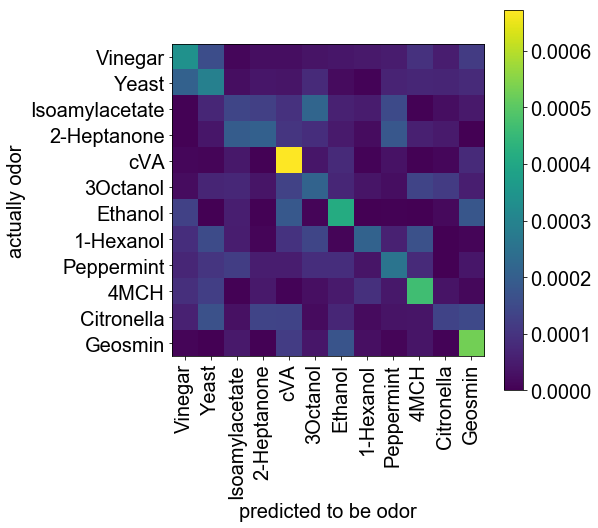

In [272]:
for i in range(ConfMat.shape[0]):
    print(np.nansum(ConfMat[i,:]))
    ConfmatNorm[i,:]=ConfMat[i,:]/np.nansum(ConfMat[i,:])

print("Accurancy:", np.mean(Ac))
print("Chance:",np.mean(Chance))
plt.figure(figsize=(7, 7))
im=plt.imshow(np.mean(ConfmatNorm,2))
plt.xticks(range(12),OdorID_map.keys(),rotation='vertical')
plt.yticks(range(12),OdorID_map.keys())
plt.xlabel("predicted to be odor")
plt.ylabel("actually odor")
plt.colorbar(im)
plt.savefig('SVMclass.svg')
plt.savefig('SVMclass.png')

In [275]:
## CLASSIFIER - Evaluation of the techniques via confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn import svm
 
plt.figure(figsize=(7, 7))
classifier = svm.LinearSVC(class_weight="balanced",max_iter=2000)
 
def perform_evaluation(feature_set,target_set):
    def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj]
    feat_train, feat_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.2)
    classifier.fit(feat_train, target_train)
    predicted = classifier.predict(feat_test)
    Ac=accuracy_score(target_test, predicted)    
    yrand=np.zeros((len(target_test)))
    for i in range(len(target_test)):
        yrand[i]=randint(0, 11)        
    Chance=accuracy_score(yrand, predicted)
    ConfMat=confusion_matrix(target_test, predicted)
    return Ac, ConfMat, Chance

Acc=np.zeros((1000))
Chancec=np.zeros((1000))
ConfMatc=np.zeros((12,12,1000))
for i in range(1000):
    y_chance=np.random.choice(range(12), size=(Samples,))
    clf.fit(X, y_chance.reshape((Samples,)))
    X_lda_chance = clf.fit(X,y_chance.reshape((Samples,))).transform(X)
    [Achelp, ConfMathelp, Chancehelp]=perform_evaluation(X_lda_chance, y_chance.reshape((Samples,)))
    while ConfMathelp.shape[0]==11:
        y_chance=np.random.choice(range(12), size=(Samples,))
        [Achelp, ConfMathelp, Chancehelp]=perform_evaluation(X_lda_chance, y_chance.reshape((Samples,)))
        print(i)
    [Acc[i], ConfMatc[:,:,i], Chancec[i]]=[Achelp, ConfMathelp, Chancehelp]

100


C:\Users\aimon\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\aimon\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


774


C:\Users\aimon\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


977


C:\Users\aimon\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<Figure size 504x504 with 0 Axes>

In [276]:
len(Ac[Ac>np.mean(Ac)])/len(Ac)

0.0

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ]),
 <a list of 20 Patch objects>)

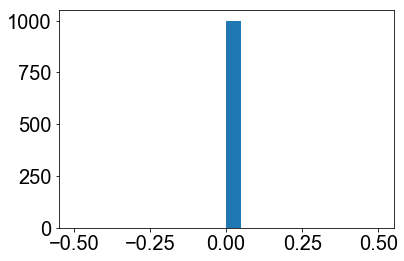

In [277]:
plt.hist(Ac,20)

In [278]:
for i in range(ConfMatc.shape[0]):
    print(np.nansum(ConfMatc[i,:]))
    ConfmatNormc[i,:]=ConfMatc[i,:]/np.nansum(ConfMatc[i,:])


print("Accurancy (actual chance level):", np.mean(Acc))
print("Chance:",np.mean(Chancec))
plt.figure(figsize=(7, 7))
plt.imshow(np.mean(ConfMatNormc,2))
plt.xticks(range(12),OdorID_map.keys(),rotation='vertical')
plt.yticks(range(12),OdorID_map.keys())
plt.xlabel("predicted to be odor")
plt.ylabel("actually odor")
plt.savefig('SVMclassChance.svg')
plt.savefig('SVMclassChance.png')

5607.0


NameError: name 'ConfmatNormc' is not defined

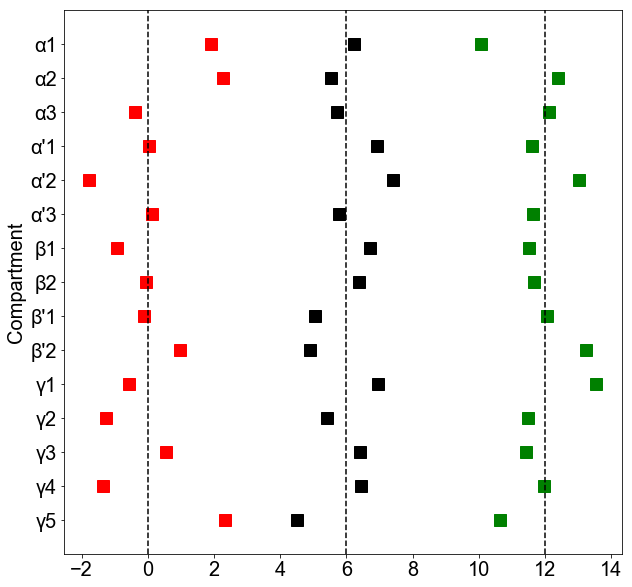

In [237]:
fig = plt.figure(figsize=(10, 10))
mpl.rcParams.update({'font.size': 20})

plt.plot(clf.coef_[0,::-1].T,range(15),'s',markersize=12,color='red')
plt.ylabel('Compartment')
plt.yticks(range(15),
           LobesGreek[::-1])
# draw vertical line from (70,100) to (70, 250)
plt.plot([0, 0], [-1, 16], linestyle='--',color='black')

plt.plot(6+clf.coef_[1,::-1].T,range(15),'s',markersize=12,color='black')
plt.ylabel('Compartment')
plt.yticks(range(15),
           LobesGreek[::-1])
# draw vertical line from (70,100) to (70, 250)
plt.plot([6, 6], [-1, 16], linestyle='--',color='black')
#plt.axis.axhline(x=0, linestyle='--', color='black', linewidth=4)

plt.plot(12+clf.coef_[2,::-1].T,range(15),'s',markersize=12,color='green')
plt.ylabel('Compartment')
plt.yticks(range(15),
           LobesGreek[::-1])
# draw vertical line from (70,100) to (70, 250)
plt.plot([12, 12], [-1, 16], linestyle='--',color='black')

plt.ylim([-1,15])
fig.savefig('StimulusLDAComponents.svg')
fig.savefig('StimulusLDAComponents.png')


# LDA state space

In [238]:
X_r=X_lda

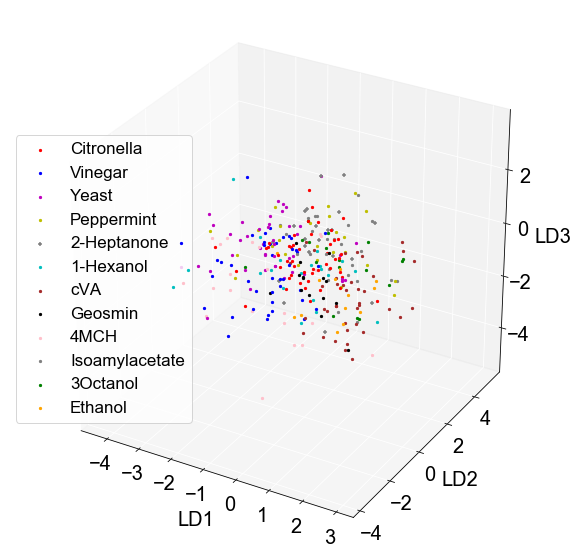

In [239]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 40
mpl.rcParams['legend.fontsize'] = 17
mpl.rcParams['grid.color'] = 'w'
mpl.rcParams['figure.facecolor'] = '1'
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
[v,y,c,p,o3,m4,h1,e,cv,g,iso,h2,hp1,hx1]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(Samples):
    if lobe_data.hours_starved[i*15]!=12:
    #print(lobe_data.stimulus[i*15])
        if lobe_data.stimulus[i*15]=='Vinegar':
            if v==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='b',marker='.',label='Vinegar')
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='b',marker='.')
            v=v+1
        elif lobe_data.stimulus[i*15]=='Yeast':
            if y==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='m',marker='.',label="Yeast")
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='m',marker='.')
            y=y+1
        elif lobe_data.stimulus[i*15]=='Citronella':
            if c==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='r',marker='.',label="Citronella") 
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='r',marker='.') 
            c=c+1
        elif lobe_data.stimulus[i*15]=='Peppermint':
            if p==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='y',marker='.',label="Peppermint") 
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='y',marker='.') 
            p=p+1
        elif lobe_data.stimulus[i*15]=='3Octanol':
            if o3==0:   
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='g',marker='.',label="3Octanol")   
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='g',marker='.')  
            o3=o3+1
        elif lobe_data.stimulus[i*15]=='4MCH':
            if m4==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='pink',marker='.',label="4MCH") 
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='pink',marker='.')
            m4=m4+1
        elif lobe_data.stimulus[i*15]=='1-Hexanol':
            if h1==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='c',marker='.',label="1-Hexanol")     
                h1=1
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='c',marker='.')    
            h1=h1+1
        elif lobe_data.stimulus[i*15]=='Ethanol':
            if e==0:    
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='orange',marker='.',label="Ethanol")  
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='orange',marker='.')      
            e=e+1
        elif lobe_data.stimulus[i*15]=='cVA':
            if cv==0: 
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='brown',marker='.',label="cVA")  
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='brown',marker='.')  
            cv=cv+1
        elif lobe_data.stimulus[i*15]=='Geosmin':
            if g==0:    
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='black',marker='.',label="Geosmin")      
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='black',marker='.') 
            g=g+1
        elif lobe_data.stimulus[i*15]=='Isoamylacetate':
            if iso==0: 
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='grey',marker='.',label="Isoamylacetate")  
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='grey',marker='.') 
            iso=iso+1
        elif lobe_data.stimulus[i*15]=='2-Heptanone':
            if h2==0: 
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='grey',marker='+',label="2-Heptanone") 
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='grey',marker='+') 
            h2=h2+1

ax.set_xlabel('LD1',labelpad=12)      
ax.set_ylabel('LD2',labelpad=12) 
ax.set_zlabel('LD3',labelpad=12)
ax.legend(loc='center left')
fig.savefig('AllOdorsScatter.svg')
fig.savefig('AllOdorsScatter.png')

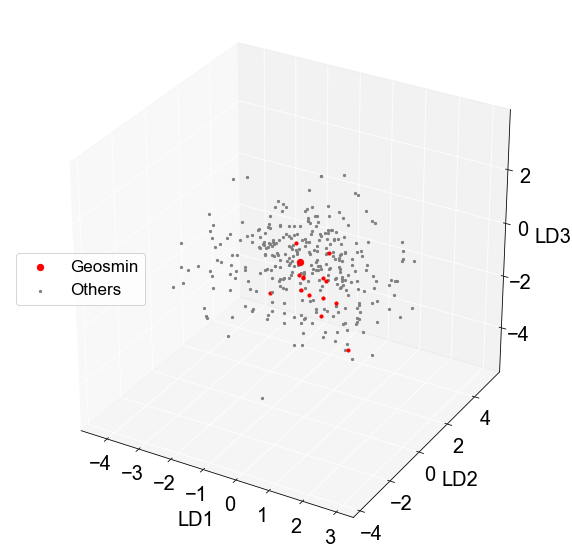

In [240]:

mpl.rcParams['lines.markersize'] = 20
mpl.rcParams['legend.fontsize'] = 17
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
g=0
k=0
for i in range(Samples):
    if lobe_data.hours_starved[i*15]!=12:
    #print(lobe_data.stimulus[i*15])
        if lobe_data.stimulus[i*15]=='Geosmin':
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='red',s=40,marker='.')
            if g==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',marker='o',s=40,label="Geosmin")    
                g=1
        else:
            if k==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='grey',marker='.',label="Others")
                k=1
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='grey',marker='.')
ax.set_xlabel('LD1',labelpad=12)      
ax.set_ylabel('LD2',labelpad=12) 
ax.set_zlabel('LD3',labelpad=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center left')

fig.savefig('GeosminScatter.svg')

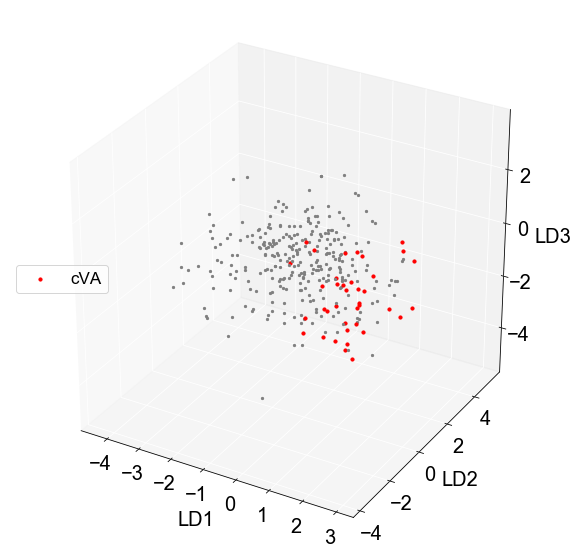

In [241]:
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['lines.markersize'] = 30
mpl.rcParams['legend.fontsize'] = 17
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
g=0
for i in range(Samples):
    if lobe_data.hours_starved[i*15]!=12:
    #print(lobe_data.stimulus[i*15])
        if lobe_data.stimulus[i*15]!='cVA':
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='grey',marker='.')
        elif lobe_data.stimulus[i*15]=='cVA':
            if g==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.',label="cVA")    
                g=1
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.')              
ax.set_xlabel('LD1',labelpad=12)      
ax.set_ylabel('LD2',labelpad=12) 
ax.set_zlabel('LD3',labelpad=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center left') 
fig.savefig('cVA.svg')
fig.savefig('cVA.png')

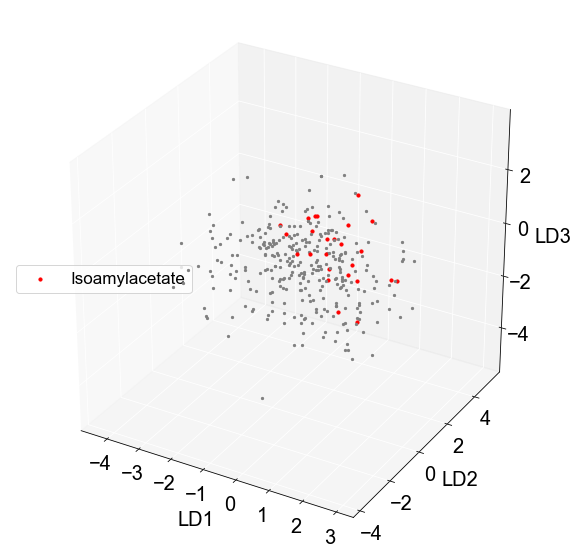

In [242]:
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['legend.fontsize'] = 17
mpl.rcParams['lines.markersize'] = 30
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
g=0
for i in range(Samples):
    if lobe_data.hours_starved[i*15]!=12:
    #print(lobe_data.stimulus[i*15])
        if lobe_data.stimulus[i*15]!='Isoamylacetate':
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='grey',marker='.')
        elif lobe_data.stimulus[i*15]=='Isoamylacetate':
            if g==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.',label="Isoamylacetate")    
                g=1
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.')   
ax.set_xlabel('LD1',labelpad=12)      
ax.set_ylabel('LD2',labelpad=12) 
ax.set_zlabel('LD3',labelpad=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='center left')
fig.savefig('Isoamylacetate.svg')

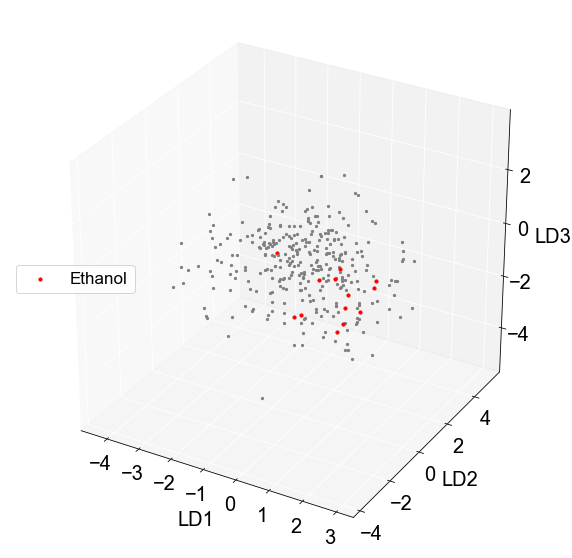

In [243]:

mpl.rcParams['legend.fontsize'] = 17
mpl.rcParams['lines.markersize'] = 30
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
g=0
for i in range(Samples):
    if lobe_data.hours_starved[i*15]!=12:
    #print(lobe_data.stimulus[i*15])
        if lobe_data.stimulus[i*15]!='Ethanol':
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='grey',marker='.')
        elif lobe_data.stimulus[i*15]=='Ethanol':
            if g==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.',label="Ethanol")    
                g=1
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.')   
ax.set_xlabel('LD1',labelpad=12)      
ax.set_ylabel('LD2',labelpad=12) 
ax.set_zlabel('LD3',labelpad=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='center left')
fig.savefig('Ethanol.svg')

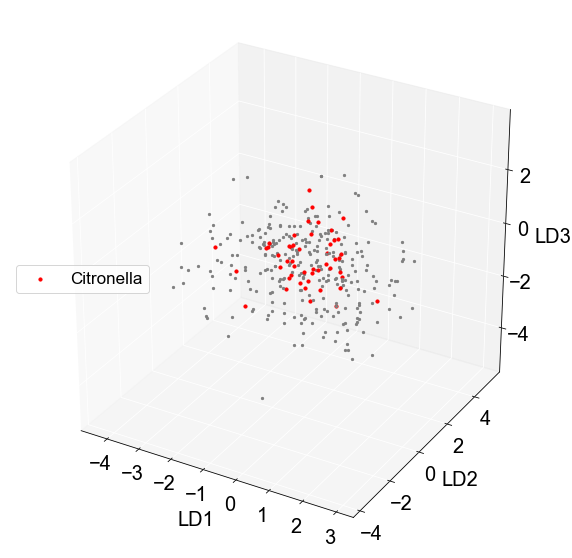

In [244]:

mpl.rcParams['legend.fontsize'] = 17
mpl.rcParams['lines.markersize'] = 30
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
g=0
for i in range(Samples):
    if lobe_data.hours_starved[i*15]!=12:
    #print(lobe_data.stimulus[i*15])
        if lobe_data.stimulus[i*15]!='Citronella':
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='grey',marker='.')
        elif lobe_data.stimulus[i*15]=='Citronella':
            if g==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.',label="Citronella")    
                g=1
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.')   
ax.set_xlabel('LD1',labelpad=12)      
ax.set_ylabel('LD2',labelpad=12) 
ax.set_zlabel('LD3',labelpad=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='center left')
fig.savefig('Citronella.svg')

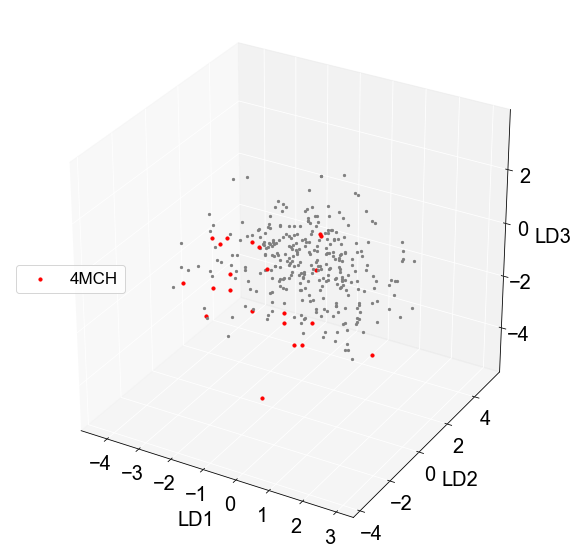

In [245]:

mpl.rcParams['legend.fontsize'] = 17
mpl.rcParams['lines.markersize'] = 30
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
g=0
for i in range(Samples):
    if lobe_data.hours_starved[i*15]!=12:
    #print(lobe_data.stimulus[i*15])
        if lobe_data.stimulus[i*15]!='4MCH':
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='grey',marker='.')
        elif lobe_data.stimulus[i*15]=='4MCH':
            if g==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.',label="4MCH")    
                g=1
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.')   
ax.set_xlabel('LD1',labelpad=12)      
ax.set_ylabel('LD2',labelpad=12) 
ax.set_zlabel('LD3',labelpad=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='center left')
fig.savefig('4MCH.svg')
fig.savefig('4MCH.png')


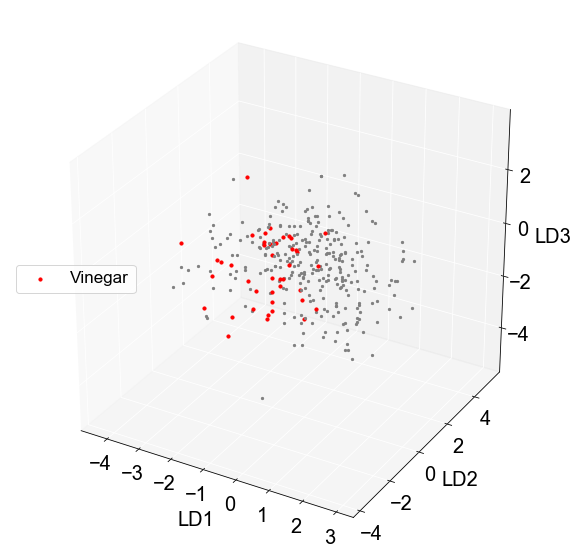

In [246]:
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['legend.fontsize'] = 17
mpl.rcParams['lines.markersize'] = 30
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
g=0
for i in range(Samples):
    if lobe_data.hours_starved[i*15]!=12:
    #print(lobe_data.stimulus[i*15])
        if lobe_data.stimulus[i*15]!='Vinegar':
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='grey',marker='.')
        elif lobe_data.stimulus[i*15]=='Vinegar':
            if g==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.',label="Vinegar")    
                g=1
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.')   
ax.set_xlabel('LD1',labelpad=12)      
ax.set_ylabel('LD2',labelpad=12) 
ax.set_zlabel('LD3',labelpad=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='center left')
fig.savefig('Vinegar.svg')

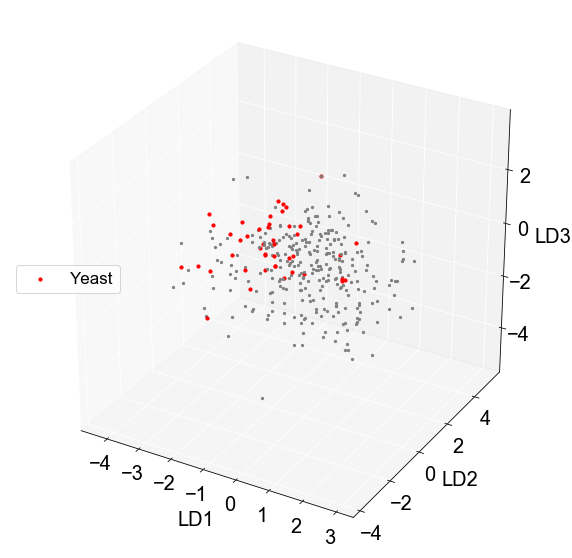

In [247]:
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['legend.fontsize'] = 17
mpl.rcParams['lines.markersize'] = 30
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
g=0
for i in range(Samples):
    if lobe_data.hours_starved[i*15]!=12:
    #print(lobe_data.stimulus[i*15])
        if lobe_data.stimulus[i*15]!='Yeast':
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='grey',marker='.')
        elif lobe_data.stimulus[i*15]=='Yeast':
            if g==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.',label='Yeast')    
                g=1
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.')   
ax.set_xlabel('LD1',labelpad=12)      
ax.set_ylabel('LD2',labelpad=12) 
ax.set_zlabel('LD3',labelpad=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='center left')
fig.savefig('Yeast.svg')

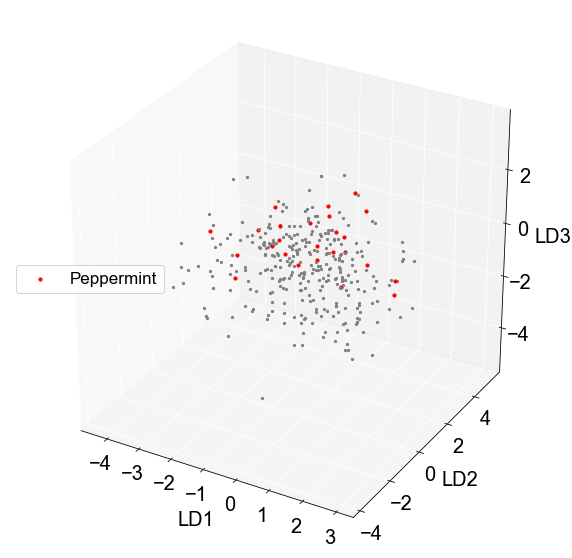

In [248]:
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['legend.fontsize'] = 17
mpl.rcParams['lines.markersize'] = 30
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
g=0
for i in range(Samples):
    if lobe_data.hours_starved[i*15]!=12:
    #print(lobe_data.stimulus[i*15])
        if lobe_data.stimulus[i*15]!='Peppermint':
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='grey',marker='.')
        elif lobe_data.stimulus[i*15]=='Peppermint':
            if g==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.',label='Peppermint')    
                g=1
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.')   
ax.set_xlabel('LD1',labelpad=12)      
ax.set_ylabel('LD2',labelpad=12) 
ax.set_zlabel('LD3',labelpad=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='center left')
fig.savefig('Peppermint.svg')

# Old stuff

# LDA Stimulus type

Peppermint: terpenes? It is also mix, so difficult to classify
Citronella: terpene? It is also mix, so difficult to classify
     
"Vinegar": acid, food-related
"Yeast": food-related
"Isoamylacetate": acid?
"2-Heptanone": ketone
"1-Heptanone":  ketone
    
"cVA": acid?, pheromone
        "3Octanol": alcohol
        "Ethanol": alcohol, food-related?

"1-Hexanol": alcohol,
"Peppermint": mix
"4MCH": alcohol
"Citronella": more like a ketone?
"Geosmin": alcohol

In [ ]:
dictionaryType={1:'ester',2:'ketone',3: 'alcohol',4:'terpene'}

In [ ]:
Odor_type=np.zeros((Samples,1))
for i in range(Samples):
    Odor_type[i]=lobe_data["odor_type"][i*15]

In [ ]:
X = Lobe_mean_activity_matrix
y = Odor_type
clf = LinearDiscriminantAnalysis()
clf.fit(X, y)
X_lda = clf.fit(X,y).transform(X)

In [ ]:
classifier = RandomForestClassifier(max_depth=2, random_state=0)
 
def perform_evaluation(feature_set,target_set):
    def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj]
    print("Evaluation for:",namestr(feature_set,globals())[0])
    feat_train, feat_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.2, random_state=3)
# pass initial state to generate same indexes
 
    classifier.fit(feat_train, target_train)
    predicted = classifier.predict(feat_test)
    #In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
    print("Accuracy: ",accuracy_score(target_test, predicted))
    Chance=1/np.max(target_set)
    print("Chance: "+str(Chance))
    print(confusion_matrix(target_test, predicted))
 
perform_evaluation(X_lda, y)


In [ ]:
X_r=X_lda

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 30
mpl.rcParams['legend.fontsize'] = 12
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
[v,y,c,p,o3,m4,h1,e,cv,g,iso,h2,hp1,hx1]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(Samples):
    #print(lobe_data.stimulus[i*15])
    if lobe_data.odor_type[i*15]==1:
        if v==0:
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='b',marker='.',label=dictionaryType[1])
            v=1
         
        else:
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='b',marker='.')
    elif lobe_data.odor_type[i*15]==2:
        if y==0:
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='m',marker='.',label=dictionaryType[2])
            y=1
        else:
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='m',marker='.')
    elif lobe_data.odor_type[i*15]==3:
        if c==0:
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='r',marker='.',label=dictionaryType[3]) 
            c=1
        else:
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='r',marker='.') 
    elif lobe_data.odor_type[i*15]==4:
        if p==0:
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='y',marker='.',label=dictionaryType[4]) 
            p=1
        else:
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='y',marker='.')        
            
ax.legend()

# PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_r = pca.fit(X).transform(X)

In [ ]:
fig = plt.figure(figsize=(10, 10))
mpl.rcParams.update({'font.size': 20})

plt.plot(clf.coef_[0,::-1].T,range(15),'s',markersize=12,color='red')
plt.ylabel('Compartment')
plt.yticks(range(15),
           LobesGreek[::-1])
# draw vertical line from (70,100) to (70, 250)
plt.plot([0, 0], [-1, 16], linestyle='--',color='black')

plt.plot(6+clf.coef_[1,::-1].T,range(15),'s',markersize=12,color='black')
plt.ylabel('Compartment')
plt.yticks(range(15),
           LobesGreek[::-1])
# draw vertical line from (70,100) to (70, 250)
plt.plot([6, 6], [-1, 16], linestyle='--',color='black')
#plt.axis.axhline(x=0, linestyle='--', color='black', linewidth=4)

plt.plot(12+clf.coef_[2,::-1].T,range(15),'s',markersize=12,color='green')
plt.ylabel('Compartment')
plt.yticks(range(15),
           LobesGreek[::-1])
# draw vertical line from (70,100) to (70, 250)
plt.plot([12, 12], [-1, 16], linestyle='--',color='black')

plt.ylim([-1,15])
fig.savefig('PCAComponents.svg')
fig.savefig('PCAComponents.png')


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
for i in range(Samples):
    #print(lobe_data.stimulus[i*15])
    if lobe_data.stimulus[i*15]=='Vinegar':
        ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='g',marker='.')
    elif lobe_data.stimulus[i*15]=='Yeast':
        ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='c',marker='.')
    elif lobe_data.stimulus[i*15]=='Citronella':
        ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='r',marker='.')
    elif lobe_data.stimulus[i*15]=='Peppermint':
        ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='m',marker='.')
    #else:
     #   ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],'y.')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['legend.fontsize'] = 17
mpl.rcParams['lines.markersize'] = 30
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
g=0
for i in range(Samples):
    if lobe_data.hours_starved[i*15]!=12:
    #print(lobe_data.stimulus[i*15])
        if lobe_data.stimulus[i*15]!='Vinegar':
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='grey',marker='.')
        elif lobe_data.stimulus[i*15]=='Vinegar':
            if g==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.',label="Vinegar")    
                g=1
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.')   
ax.set_xlabel('PC1',labelpad=12)      
ax.set_ylabel('PC2',labelpad=12) 
ax.set_zlabel('PC3',labelpad=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='center left')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['legend.fontsize'] = 17
mpl.rcParams['lines.markersize'] = 30
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
g=0
for i in range(Samples):
    if lobe_data.hours_starved[i*15]!=12:
    #print(lobe_data.stimulus[i*15])
        if lobe_data.stimulus[i*15]!='Peppermint':
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='grey',marker='.')
        elif lobe_data.stimulus[i*15]=='Peppermint':
            if g==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.',label='Peppermint')    
                g=1
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.')   
ax.set_xlabel('PC1',labelpad=12)      
ax.set_ylabel('PC2',labelpad=12) 
ax.set_zlabel('PC3',labelpad=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='center left')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['legend.fontsize'] = 17
mpl.rcParams['lines.markersize'] = 30
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
g=0
for i in range(Samples):
    if lobe_data.hours_starved[i*15]!=12:
    #print(lobe_data.stimulus[i*15])
        if lobe_data.stimulus[i*15]!='4MCH':
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='grey',marker='.')
        elif lobe_data.stimulus[i*15]=='4MCH':
            if g==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.',label="4MCH")    
                g=1
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.')   
ax.set_xlabel('PC1',labelpad=12)      
ax.set_ylabel('PC2',labelpad=12) 
ax.set_zlabel('PC3',labelpad=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='center left')

In [ ]:
mpl.rcParams['legend.fontsize'] = 17
mpl.rcParams['lines.markersize'] = 30
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
g=0
for i in range(Samples):
    if lobe_data.hours_starved[i*15]!=12:
    #print(lobe_data.stimulus[i*15])
        if lobe_data.stimulus[i*15]!='Ethanol':
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='grey',marker='.')
        elif lobe_data.stimulus[i*15]=='Ethanol':
            if g==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.',label="Ethanol")    
                g=1
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.')   
ax.set_xlabel('PC1',labelpad=12)      
ax.set_ylabel('PC2',labelpad=12) 
ax.set_zlabel('PC3',labelpad=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='center left')

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
g=0
for i in range(Samples):
    if lobe_data.hours_starved[i*15]!=12:
    #print(lobe_data.stimulus[i*15])
        if lobe_data.stimulus[i*15]!='Isoamylacetate':
            ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='grey',marker='.')
        elif lobe_data.stimulus[i*15]=='Isoamylacetate':
            if g==0:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.',label="Isoamylacetate")    
                g=1
            else:
                ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],color='red',s=40,marker='.')   
ax.set_xlabel('PC1',labelpad=12)      
ax.set_ylabel('PC2',labelpad=12) 
ax.set_zlabel('PC3',labelpad=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='center left')

In [ ]:
pca_components = pca.components_

In [ ]:
pca_components.shape

In [ ]:
lobes

In [ ]:
plt.figure(figsize=(14, 4))
plt.plot(pca_components[0])
plt.xlabel('Lobe')
plt.xticks(range(15),
           lobes)
plt.show()

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X_r,
    lobe_data.valence[np.array(range(Samples))*15], train_size=0.7)

lr = linear_model.LogisticRegression()
lr.fit(train_x, train_y)

print("Logistic regression Train Accuracy ::", metrics.accuracy_score(train_y, lr.predict(train_x)))
print("Logistic regression Test Accuracy ::", metrics.accuracy_score(test_y, lr.predict(test_x)))

# Tensor PCA

In [ ]:
import tensorly as tl
from tensorly.decomposition._tucker import partial_tucker

class TensorPCA:
    def __init__(self, ranks, modes):
        self.ranks = ranks
        self.modes = modes

    def fit(self, tensor):
        self.core, self.factors = partial_tucker(tensor, modes=self.modes, ranks=self.ranks)
        return self

    def transform(self, tensor):
        return tl.tenalg.multi_mode_dot(tensor, self.factors, modes=self.modes, transpose=True)

In [ ]:
Lobe_odor_tensor.shape

In [ ]:
tpca = TensorPCA(ranks=[3,15,80], modes=[0])
tpca.fit(Lobe_odor_tensor)

In [ ]:
Lobe_odor_tensor.shape

In [ ]:
tpca.transform(Lobe_odor_tensor).shape

In [ ]:
tpca.core.shape

In [ ]:
del Mode1

In [ ]:
tpca.factors[0].shape

In [ ]:
Mode1=tpca.factors[1][:,0]

In [ ]:
Mode1=-tpca.core[0,5,:]

In [ ]:
Mode1.shape

In [ ]:
plt.plot(Mode1)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
for c, z in zip(['r', 'g', 'b', 'y','r', 'g', 'b', 'y','r', 'g', 'b', 'y','r', 'g','y'], range(15)):
    xs = np.arange(80)
    ys = -tpca.core[0,z,:]

    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    cs = [c] * len(xs)
    cs[0] = 'c'
    ax.bar(xs, ys, zs=z, zdir='y', color=cs, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Lobe')
ax.set_yticks(range(2,17))
ax.set_yticklabels(lobes)
ax.set_zlabel('Z')

plt.show()

In [ ]:
X_r=tpca.factors[0]

In [ ]:
plt.figure(figsize=(14, 10))
for i in range(232):
    if lobe_data.hours_starved[i*15]==48:
    #print(lobe_data.stimulus[i*15])
        if lobe_data.stimulus[i*15]=='Vinegar':
            plt.plot(X_r[i,0],X_r[i,1],'g.')
        elif lobe_data.stimulus[i*15]=='Yeast':
            plt.plot(X_r[i,0],X_r[i,1],'c.')
        elif lobe_data.stimulus[i*15]=='Citronella':
            plt.plot(X_r[i,0],X_r[i,1],'r.') 
        elif lobe_data.stimulus[i*15]=='Peppermint':
            plt.plot(X_r[i,0],X_r[i,1],'m.')     
    #else:
        #plt.plot(X_r[i,0],X_r[i,1],'y.')

In [ ]:
plt.figure(figsize=(14, 10))
for i in range(232):
    if lobe_data.hours_starved[i*15]==48:
    #print(lobe_data.stimulus[i*15])
        if lobe_data.stimulus[i*15]=='Vinegar':
            plt.plot(X_r[i,0],X_r[i,1],'g.')
        elif lobe_data.stimulus[i*15]=='Yeast':
            plt.plot(X_r[i,0],X_r[i,1],'c.')
        elif lobe_data.stimulus[i*15]=='Citronella':
            plt.plot(X_r[i,0],X_r[i,1],'r.') 
        elif lobe_data.stimulus[i*15]=='Peppermint':
            plt.plot(X_r[i,0],X_r[i,1],'m.')     
    #else:
        #plt.plot(X_r[i,0],X_r[i,1],'y.')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
for i in range(232):
    #print(lobe_data.stimulus[i*15])
    if lobe_data.stimulus[i*15]=='Vinegar':
        ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='g',marker='.')
    elif lobe_data.stimulus[i*15]=='Yeast':
        ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='c',marker='.')
    elif lobe_data.stimulus[i*15]=='Citronella':
        ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='r',marker='.')
    elif lobe_data.stimulus[i*15]=='Peppermint':
        ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],c='m',marker='.')
    else:
        ax.scatter(X_r[i,0],X_r[i,1],X_r[i,2],'y.')

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X_r,
    lobe_data.valence[np.array(range(232))*15], train_size=0.7)

In [ ]:
lr = linear_model.LogisticRegression(solver = 'lbfgs')
lr.fit(train_x, train_y)

In [ ]:
print("Logistic regression Train Accuracy ::", metrics.accuracy_score(train_y, lr.predict(train_x)))
print("Logistic regression Test Accuracy ::", metrics.accuracy_score(test_y, lr.predict(test_x)))

# K means

In [ ]:
from time import time
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

np.random.seed(42)

data = scale(digits.data)
n_digits=13
labels = lobe_data.stimulus[range(232)*15]

sample_size = 232


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()